# Assignment 2

Akos Engelmann, Simon Jasansky

## 0. Loading, inspecting and preprocessing data

In [59]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [60]:
# we don't need to load the y_train and y_test, as we will not use the labels of the image
(x_train, _), (x_test, _) = tf.keras.datasets.cifar10.load_data()

In [61]:
# split the test data into test and validation
data = np.concatenate((x_train, x_test))
print(data.shape)
# the shape is as expected, 60000 samples with 32x32 pictures, with 3 layers (RGB)

(60000, 32, 32, 3)


(32, 32, 3)
(32, 3)
(3,)
[59 62 63]


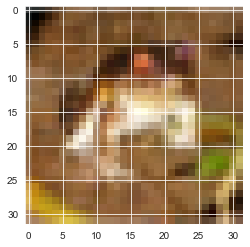

In [62]:
# first picture
print(data[0].shape)

# first row of pixels of the picture
print(data[0][0].shape)

# first pixel of the first row/column of the picture (RGB values)
print(data[0][0][0].shape)
print(data[0][0][0])

# print the first picture
plt.imshow(data[0])
plt.show()

In [63]:
data = data.astype("float32")
# data_norm = tf.keras.utils.normalize(data, axis = 1, order = 1)
# data_norm

In [64]:
# normalize data
data = data.astype("float32")
data = data/255

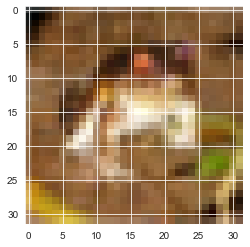

In [65]:
# print the first picture again (normalized)
plt.imshow(data[0])
plt.show()

In [26]:
# reshuffle before splitting data
# probably not needed as
# np.random.shuffle(data)

# split into train, test and validation sets
train = data[:48000]
test = data[48000:54000]
valid = data[54000:]

print(train.shape)
print(test.shape)
print(valid.shape)

(48000, 32, 32, 3)
(6000, 32, 32, 3)
(6000, 32, 32, 3)


## 1. Basic Model

In [27]:
# implement CAE
input_layer = tf.keras.layers.Input(shape=(32, 32, 3), name="INPUT")
# shape now: 32x32x3

x = tf.keras.layers.Conv2D(filters = 8, kernel_size = (3, 3), strides = 1, activation='relu', padding='same')(input_layer)
# shape now: 32x32x8

x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), padding = "same")(x)
x = tf.keras.layers.Conv2D(filters = 12, kernel_size = (3, 3), strides = 1, activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), padding = "same")(x)

# Latent space is a Conv2D layer, after the MaxPooling and before the UpSampling
latent_space_rep = tf.keras.layers.Conv2D(filters = 16, kernel_size = (3, 3), strides = 1, activation='relu', padding='same', name = "LATENT_SPACE")(x)

x = tf.keras.layers.UpSampling2D((2, 2))(latent_space_rep)
x = tf.keras.layers.Conv2D(12, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
output_layer = tf.keras.layers.Conv2D(3, (3, 3), padding='same', name="OUTPUT")(x)
# shape now: 32x32x3

In [28]:
pic_CAE = tf.keras.models.Model(input_layer, output_layer)
pic_CAE.compile(optimizer='adam', loss='mse', metrics=["accuracy"])
pic_CAE.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
INPUT (InputLayer)           [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 8)         224       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 12)        876       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 12)          0         
_________________________________________________________________
LATENT_SPACE (Conv2D)        (None, 8, 8, 16)          1744      
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 16, 16, 16)       

In [29]:
# train the model
history = pic_CAE.fit(x = train,
                      y = train,
                      epochs=10,
                      batch_size=64,
                      shuffle=True,
                      validation_data = (valid, valid)) #change this in other version to valid

Epoch 1/10
750/750 [==============================] - 66s 88ms/step - loss: 0.0157 - accuracy: 0.6131 - val_loss: 0.0077 - val_accuracy: 0.7170
Epoch 2/10
750/750 [==============================] - 63s 84ms/step - loss: 0.0069 - accuracy: 0.7316 - val_loss: 0.0064 - val_accuracy: 0.7454
Epoch 3/10
750/750 [==============================] - 63s 85ms/step - loss: 0.0061 - accuracy: 0.7516 - val_loss: 0.0058 - val_accuracy: 0.7603
Epoch 4/10
750/750 [==============================] - 63s 84ms/step - loss: 0.0057 - accuracy: 0.7630 - val_loss: 0.0055 - val_accuracy: 0.7713
Epoch 5/10
750/750 [==============================] - 65s 86ms/step - loss: 0.0054 - accuracy: 0.7697 - val_loss: 0.0052 - val_accuracy: 0.7740
Epoch 6/10
750/750 [==============================] - 65s 87ms/step - loss: 0.0051 - accuracy: 0.7746 - val_loss: 0.0050 - val_accuracy: 0.7795
Epoch 7/10
750/750 [==============================] - 63s 84ms/step - loss: 0.0050 - accuracy: 0.7788 - val_loss: 0.0048 - val_accuracy:

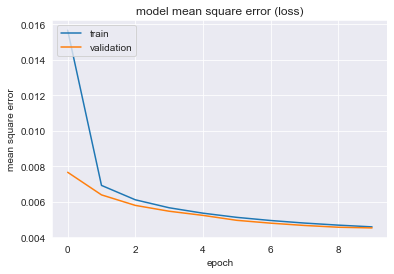

In [30]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model mean square error (loss)')
plt.ylabel('mean square error')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

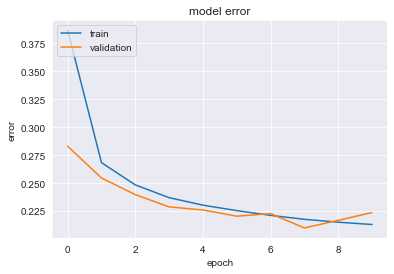

In [32]:
plt.plot(np.ones(len(history.history["accuracy"])) - history.history['accuracy'])
plt.plot(np.ones(len(history.history["accuracy"])) - history.history['val_accuracy'])
plt.title('model error')
plt.ylabel('error')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [41]:
# make model to get intermediate representation in latent space to check size of the intermediate layer
get_encoded_pic = tf.keras.models.Model(inputs=pic_CAE.input, outputs=pic_CAE.get_layer("LATENT_SPACE").output)
# get the intermediate pictures
encoded_pic = get_encoded_pic.predict(test)
print(encoded_pic.shape)
encoded_pic_adj = encoded_pic.reshape((len(test), 8*8*16))
print(encoded_pic_adj.shape)

(6000, 8, 8, 16)
(6000, 1024)


The size of the latent space representation is 1024

In [34]:
# get the reconstructed pics
reconstructed_pics = pic_CAE.predict(test)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


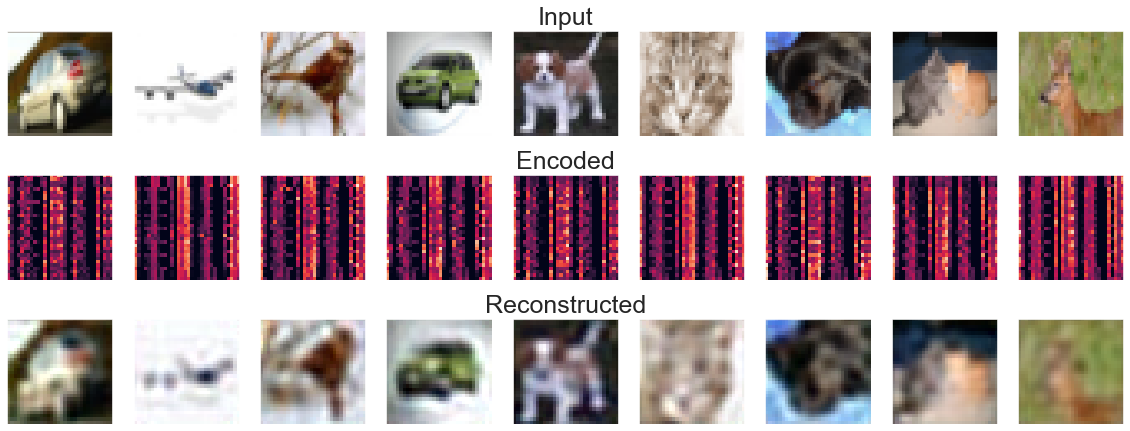

In [55]:
def plot_cae(normalized, encoded, reconstructed):
    # plot the input and reconstructed pictures
    ncols = 9
    nrows = 3

    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(20, 7.5))

    for row in range(nrows):
        for col in range(ncols):
            if row == 0: # normalized
                axs[row, col].imshow(normalized[col])
                if col == 4:
                    axs[row, col].set_title("Input", size = 25)
            if row == 1: # encoded
                axs[row, col].imshow(encoded[col].reshape(32,32))
                if col == 4:
                    axs[row, col].set_title("Encoded", size = 25)
            if row == 2: # reconstructed
                axs[row, col].imshow(reconstructed[col])
                if col == 4:
                    axs[row, col].set_title("Reconstructed", size = 25)
            axs[row, col].set_xticks([])
            axs[row, col].set_yticks([])

    plt.show()

plot_cae(test, encoded_pic, reconstructed_pics)

## 2. Trying different parameters

### 2.0 doubling the number of epochs (10 -> 20)

In [29]:
pic_CAE = tf.keras.models.Model(input_layer, output_layer)
pic_CAE.compile(optimizer='adam', loss='mse', metrics=["accuracy"])
# train the model again with 20 epochs
history = pic_CAE.fit(x = train,
                      y = train,
                      epochs=20,
                      batch_size=64,
                      shuffle=True,
                      validation_data = (valid, valid)) #change this in other version to valid

Epoch 1/10
750/750 [==============================] - 66s 88ms/step - loss: 0.0157 - accuracy: 0.6131 - val_loss: 0.0077 - val_accuracy: 0.7170
Epoch 2/10
750/750 [==============================] - 63s 84ms/step - loss: 0.0069 - accuracy: 0.7316 - val_loss: 0.0064 - val_accuracy: 0.7454
Epoch 3/10
750/750 [==============================] - 63s 85ms/step - loss: 0.0061 - accuracy: 0.7516 - val_loss: 0.0058 - val_accuracy: 0.7603
Epoch 4/10
750/750 [==============================] - 63s 84ms/step - loss: 0.0057 - accuracy: 0.7630 - val_loss: 0.0055 - val_accuracy: 0.7713
Epoch 5/10
750/750 [==============================] - 65s 86ms/step - loss: 0.0054 - accuracy: 0.7697 - val_loss: 0.0052 - val_accuracy: 0.7740
Epoch 6/10
750/750 [==============================] - 65s 87ms/step - loss: 0.0051 - accuracy: 0.7746 - val_loss: 0.0050 - val_accuracy: 0.7795
Epoch 7/10
750/750 [==============================] - 63s 84ms/step - loss: 0.0050 - accuracy: 0.7788 - val_loss: 0.0048 - val_accuracy:

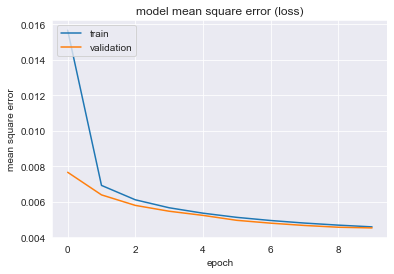

In [30]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model mean square error (loss)')
plt.ylabel('mean square error')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

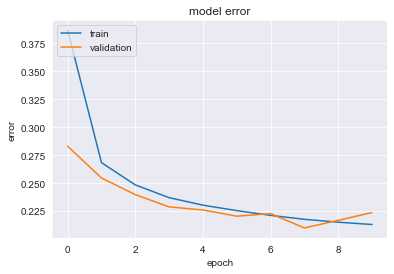

In [32]:
plt.plot(np.ones(len(history.history["accuracy"])) - history.history['accuracy'])
plt.plot(np.ones(len(history.history["accuracy"])) - history.history['val_accuracy'])
plt.title('model error')
plt.ylabel('error')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


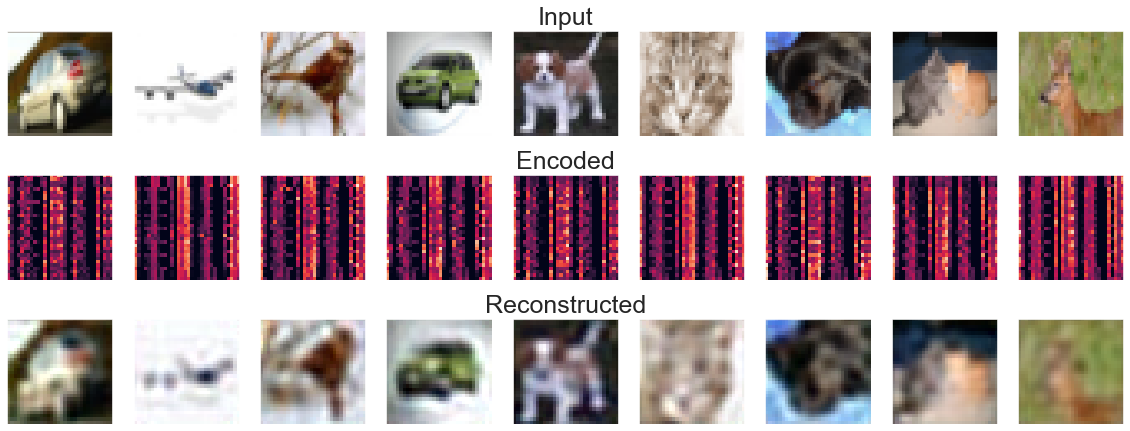

In [55]:
# make model to get intermediate representation in latent space to check size of the intermediate layer
get_encoded_pic = tf.keras.models.Model(inputs=pic_CAE.input, outputs=pic_CAE.get_layer("LATENT_SPACE").output)
encoded_pic = get_encoded_pic.predict(test)
# get the reconstructed pics
reconstructed_pics = pic_CAE.predict(test)
plot_cae(test, encoded_pic, reconstructed_pics)

### 2.1 Change number of intermediate channels

#### 2.1.1 half the amount of intermediate convolutional layers, but same amount of compression (same amount of Max-Pooling layers)

In [56]:
# implement CAE
input_layer = tf.keras.layers.Input(shape=(32, 32, 3), name="INPUT")
x = tf.keras.layers.Conv2D(filters = 8, kernel_size = (3, 3), strides = 1, activation='relu', padding='same')(input_layer)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), padding = "same")(x)
latent_space_rep = tf.keras.layers.Conv2D(filters = 16, kernel_size = (3, 3), strides = 1, activation='relu', padding='same', name = "LATENT_SPACE")(x)
x = tf.keras.layers.UpSampling2D((2, 2))(latent_space_rep)
output_layer = tf.keras.layers.Conv2D(3, (3, 3), padding='same', name="OUTPUT")(x)

In [57]:
pic_CAE = tf.keras.models.Model(input_layer, output_layer)
pic_CAE.compile(optimizer='adam', loss='mse', metrics=["accuracy"])
pic_CAE.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
INPUT (InputLayer)           [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 8)         224       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 8)         0         
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 32, 32, 8)         0         
_________________________________________________________________
OUTPUT (Conv2D)              (None, 32, 32, 3)         219       
Total params: 443
Trainable params: 443
Non-trainable params: 0
_________________________________________________________________


In [58]:
# train the model
history = pic_CAE.fit(x = train,
                      y = train,
                      epochs=10,
                      batch_size=64,
                      shuffle=True,
                      validation_data = (valid, valid))

Epoch 1/10
161/750 [=====>........................] - ETA: 33s - loss: 0.1183 - accuracy: 0.4216

KeyboardInterrupt: 

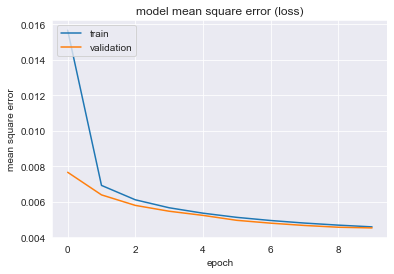

In [30]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model mean square error (loss)')
plt.ylabel('mean square error')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

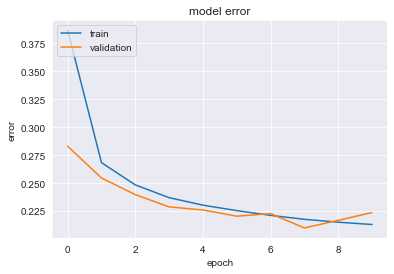

In [32]:
plt.plot(np.ones(len(history.history["accuracy"])) - history.history['accuracy'])
plt.plot(np.ones(len(history.history["accuracy"])) - history.history['val_accuracy'])
plt.title('model error')
plt.ylabel('error')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [41]:
# make model to get intermediate representation in latent space to check size of the intermediate layer
get_encoded_pic = tf.keras.models.Model(inputs=pic_CAE.input, outputs=pic_CAE.get_layer("LATENT_SPACE").output)
# get the intermediate pictures
encoded_pic = get_encoded_pic.predict(test)
print(encoded_pic.shape)
encoded_pic_adj = encoded_pic.reshape((len(test), 8*8*16))
print(encoded_pic_adj.shape)

(6000, 8, 8, 16)
(6000, 1024)


As expected, the size of the latent space representation is 1024 again, as in the basic model.

In [ ]:
# get the reconstructed pics
reconstructed_pics = pic_CAE.predict(test)
# plot the pictures
plot_cae(test, encoded_pic, reconstructed_pics)

#### 2.1.2 Double the number of intermediate convolutional layers, but same amount of compression (same amount of Max-Pooling layers)

In [27]:
# implement CAE
input_layer = tf.keras.layers.Input(shape=(32, 32, 3), name="INPUT")
x = tf.keras.layers.Conv2D(filters = 8, kernel_size = (3, 3), strides = 1, activation='relu', padding='same')(input_layer)
x = tf.keras.layers.Conv2D(filters = 8, kernel_size = (3, 3), strides = 1, activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), padding = "same")(x)
x = tf.keras.layers.Conv2D(filters = 12, kernel_size = (3, 3), strides = 1, activation='relu', padding='same')(x)
x = tf.keras.layers.Conv2D(filters = 12, kernel_size = (3, 3), strides = 1, activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), padding = "same")(x)
latent_space_rep = tf.keras.layers.Conv2D(filters = 16, kernel_size = (3, 3), strides = 1, activation='relu', padding='same', name = "LATENT_SPACE")(x)
x = tf.keras.layers.Conv2D(12, (3, 3), activation='relu', padding='same')(latent_space_rep)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(12, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.Conv2D(12, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(12, (3, 3), activation='relu', padding='same')(x)
output_layer = tf.keras.layers.Conv2D(3, (3, 3), padding='same', name="OUTPUT")(x)

In [57]:
pic_CAE = tf.keras.models.Model(input_layer, output_layer)
pic_CAE.compile(optimizer='adam', loss='mse', metrics=["accuracy"])
pic_CAE.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
INPUT (InputLayer)           [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 8)         224       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 8)         0         
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 32, 32, 8)         0         
_________________________________________________________________
OUTPUT (Conv2D)              (None, 32, 32, 3)         219       
Total params: 443
Trainable params: 443
Non-trainable params: 0
_________________________________________________________________


In [58]:
# train the model
history = pic_CAE.fit(x = train,
                      y = train,
                      epochs=10,
                      batch_size=64,
                      shuffle=True,
                      validation_data = (valid, valid))

Epoch 1/10
161/750 [=====>........................] - ETA: 33s - loss: 0.1183 - accuracy: 0.4216

KeyboardInterrupt: 

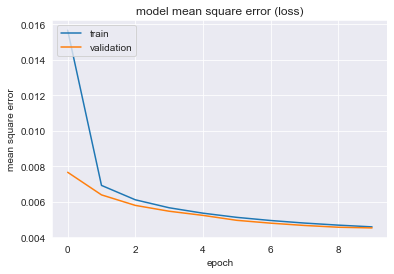

In [30]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model mean square error (loss)')
plt.ylabel('mean square error')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

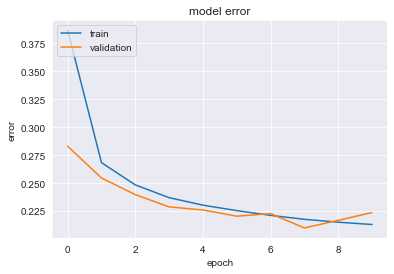

In [32]:
plt.plot(np.ones(len(history.history["accuracy"])) - history.history['accuracy'])
plt.plot(np.ones(len(history.history["accuracy"])) - history.history['val_accuracy'])
plt.title('model error')
plt.ylabel('error')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
# make model to get intermediate representation in latent space to check size of the intermediate layer
get_encoded_pic = tf.keras.models.Model(inputs=pic_CAE.input, outputs=pic_CAE.get_layer("LATENT_SPACE").output)
# get the intermediate pictures
encoded_pic = get_encoded_pic.predict(test)
# get the reconstructed pics
reconstructed_pics = pic_CAE.predict(test)
# plot the pictures
plot_cae(test, encoded_pic, reconstructed_pics)

TODO!!!!!!!!!!!!!!!!!!!!!!!!! INterpretation:

Old: Reducing the number of convolutional layers and keeping Max-pooling layers the same results in the same compression of the picture, and surprisingly also the accuracy/error rates are almost the same as for the basic model. However, the mean square error (0.0078) after the 10th epoch is considerably higher the one from the basic model (0.0048). Also, after visual inspection, the reconstructed pictures are worse compared to the basic model (as expected).

### 2.2 Different number of channels

#### 2.2.1 Double the amount of channels

In [27]:
# implement CAE with doubling the number of channels
input_layer = tf.keras.layers.Input(shape=(32, 32, 3), name="INPUT")
x = tf.keras.layers.Conv2D(filters = 16, kernel_size = (3, 3), strides = 1, activation='relu', padding='same')(input_layer)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), padding = "same")(x)
x = tf.keras.layers.Conv2D(filters = 24, kernel_size = (3, 3), strides = 1, activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), padding = "same")(x)
latent_space_rep = tf.keras.layers.Conv2D(filters = 32, kernel_size = (3, 3), strides = 1, activation='relu', padding='same', name = "LATENT_SPACE")(x)
x = tf.keras.layers.UpSampling2D((2, 2))(latent_space_rep)
x = tf.keras.layers.Conv2D(24, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
output_layer = tf.keras.layers.Conv2D(3, (3, 3), padding='same', name="OUTPUT")(x)

In [28]:
pic_CAE = tf.keras.models.Model(input_layer, output_layer)
pic_CAE.compile(optimizer='adam', loss='mse', metrics=["accuracy"])
pic_CAE.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
INPUT (InputLayer)           [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 8)         224       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 12)        876       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 12)          0         
_________________________________________________________________
LATENT_SPACE (Conv2D)        (None, 8, 8, 16)          1744      
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 16, 16, 16)       

In [29]:
# train the model
history = pic_CAE.fit(x = train,
                      y = train,
                      epochs=10,
                      batch_size=64,
                      shuffle=True,
                      validation_data = (valid, valid)) #change this in other version to valid

Epoch 1/10
750/750 [==============================] - 66s 88ms/step - loss: 0.0157 - accuracy: 0.6131 - val_loss: 0.0077 - val_accuracy: 0.7170
Epoch 2/10
750/750 [==============================] - 63s 84ms/step - loss: 0.0069 - accuracy: 0.7316 - val_loss: 0.0064 - val_accuracy: 0.7454
Epoch 3/10
750/750 [==============================] - 63s 85ms/step - loss: 0.0061 - accuracy: 0.7516 - val_loss: 0.0058 - val_accuracy: 0.7603
Epoch 4/10
750/750 [==============================] - 63s 84ms/step - loss: 0.0057 - accuracy: 0.7630 - val_loss: 0.0055 - val_accuracy: 0.7713
Epoch 5/10
750/750 [==============================] - 65s 86ms/step - loss: 0.0054 - accuracy: 0.7697 - val_loss: 0.0052 - val_accuracy: 0.7740
Epoch 6/10
750/750 [==============================] - 65s 87ms/step - loss: 0.0051 - accuracy: 0.7746 - val_loss: 0.0050 - val_accuracy: 0.7795
Epoch 7/10
750/750 [==============================] - 63s 84ms/step - loss: 0.0050 - accuracy: 0.7788 - val_loss: 0.0048 - val_accuracy:

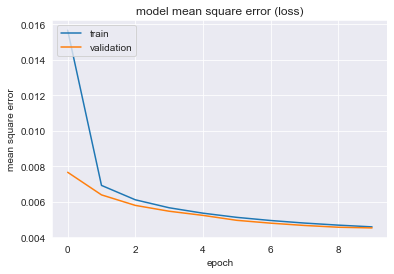

In [30]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model mean square error (loss)')
plt.ylabel('mean square error')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

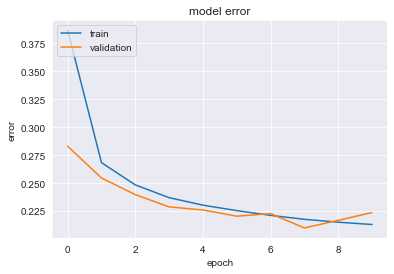

In [32]:
plt.plot(np.ones(len(history.history["accuracy"])) - history.history['accuracy'])
plt.plot(np.ones(len(history.history["accuracy"])) - history.history['val_accuracy'])
plt.title('model error')
plt.ylabel('error')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [41]:
# make model to get intermediate representation in latent space to check size of the intermediate layer
get_encoded_pic = tf.keras.models.Model(inputs=pic_CAE.input, outputs=pic_CAE.get_layer("LATENT_SPACE").output)
# get the intermediate pictures
encoded_pic = get_encoded_pic.predict(test)
print(encoded_pic.shape)
encoded_pic_adj = encoded_pic.reshape((len(test), 8*8*16))
print(encoded_pic_adj.shape)

(6000, 8, 8, 16)
(6000, 1024)


In [ ]:
# get the reconstructed pics
reconstructed_pics = pic_CAE.predict(test)
# plot the pictures
plot_cae(test, encoded_pic, reconstructed_pics)

#### 2.2.2 Half the amount of channels

In [27]:
# implement CAE with halfing the number of channels compared to basic model
input_layer = tf.keras.layers.Input(shape=(32, 32, 3), name="INPUT")
x = tf.keras.layers.Conv2D(filters = 4, kernel_size = (3, 3), strides = 1, activation='relu', padding='same')(input_layer)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), padding = "same")(x)
x = tf.keras.layers.Conv2D(filters = 6, kernel_size = (3, 3), strides = 1, activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), padding = "same")(x)
latent_space_rep = tf.keras.layers.Conv2D(filters = 8, kernel_size = (3, 3), strides = 1, activation='relu', padding='same', name = "LATENT_SPACE")(x)
x = tf.keras.layers.UpSampling2D((2, 2))(latent_space_rep)
x = tf.keras.layers.Conv2D(6, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
output_layer = tf.keras.layers.Conv2D(3, (3, 3), padding='same', name="OUTPUT")(x)

In [28]:
pic_CAE = tf.keras.models.Model(input_layer, output_layer)
pic_CAE.compile(optimizer='adam', loss='mse', metrics=["accuracy"])
pic_CAE.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
INPUT (InputLayer)           [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 8)         224       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 12)        876       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 12)          0         
_________________________________________________________________
LATENT_SPACE (Conv2D)        (None, 8, 8, 16)          1744      
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 16, 16, 16)       

In [29]:
# train the model
history = pic_CAE.fit(x = train,
                      y = train,
                      epochs=10,
                      batch_size=64,
                      shuffle=True,
                      validation_data = (valid, valid)) #change this in other version to valid

Epoch 1/10
750/750 [==============================] - 66s 88ms/step - loss: 0.0157 - accuracy: 0.6131 - val_loss: 0.0077 - val_accuracy: 0.7170
Epoch 2/10
750/750 [==============================] - 63s 84ms/step - loss: 0.0069 - accuracy: 0.7316 - val_loss: 0.0064 - val_accuracy: 0.7454
Epoch 3/10
750/750 [==============================] - 63s 85ms/step - loss: 0.0061 - accuracy: 0.7516 - val_loss: 0.0058 - val_accuracy: 0.7603
Epoch 4/10
750/750 [==============================] - 63s 84ms/step - loss: 0.0057 - accuracy: 0.7630 - val_loss: 0.0055 - val_accuracy: 0.7713
Epoch 5/10
750/750 [==============================] - 65s 86ms/step - loss: 0.0054 - accuracy: 0.7697 - val_loss: 0.0052 - val_accuracy: 0.7740
Epoch 6/10
750/750 [==============================] - 65s 87ms/step - loss: 0.0051 - accuracy: 0.7746 - val_loss: 0.0050 - val_accuracy: 0.7795
Epoch 7/10
750/750 [==============================] - 63s 84ms/step - loss: 0.0050 - accuracy: 0.7788 - val_loss: 0.0048 - val_accuracy:

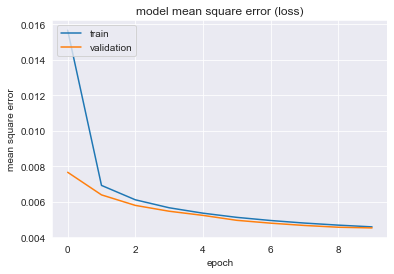

In [30]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model mean square error (loss)')
plt.ylabel('mean square error')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

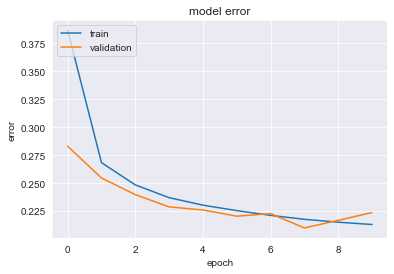

In [32]:
plt.plot(np.ones(len(history.history["accuracy"])) - history.history['accuracy'])
plt.plot(np.ones(len(history.history["accuracy"])) - history.history['val_accuracy'])
plt.title('model error')
plt.ylabel('error')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [41]:
# make model to get intermediate representation in latent space to check size of the intermediate layer
get_encoded_pic = tf.keras.models.Model(inputs=pic_CAE.input, outputs=pic_CAE.get_layer("LATENT_SPACE").output)
# get the intermediate pictures
encoded_pic = get_encoded_pic.predict(test)

(6000, 8, 8, 16)
(6000, 1024)


In [ ]:
# get the reconstructed pics
reconstructed_pics = pic_CAE.predict(test)
# plot the pictures
plot_cae(test, encoded_pic, reconstructed_pics)

### 2.3 Different filter sizes, stride and padding

#### 2.3.1 Double the filter size

In [27]:
# implement CAE
input_layer = tf.keras.layers.Input(shape=(32, 32, 3), name="INPUT")
x = tf.keras.layers.Conv2D(filters = 8, kernel_size = (3*2, 3*2), strides = 1, activation='relu', padding='same')(input_layer)
x = tf.keras.layers.MaxPooling2D(pool_size=(2*2, 2*2), padding = "same")(x)
x = tf.keras.layers.Conv2D(filters = 12, kernel_size = (3*2, 3*2), strides = 1, activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2*2, 2*2), padding = "same")(x)
latent_space_rep = tf.keras.layers.Conv2D(filters = 16, kernel_size = (3*2, 3*2), strides = 1, activation='relu', padding='same', name = "LATENT_SPACE")(x)
x = tf.keras.layers.UpSampling2D((2*2, 2*2))(latent_space_rep)
x = tf.keras.layers.Conv2D(12, (3*2, 3*2), activation='relu', padding='same')(x)
x = tf.keras.layers.UpSampling2D((2*2, 2*2))(x)
output_layer = tf.keras.layers.Conv2D(3, (3*2, 3*2), padding='same', name="OUTPUT")(x)

In [28]:
pic_CAE = tf.keras.models.Model(input_layer, output_layer)
pic_CAE.compile(optimizer='adam', loss='mse', metrics=["accuracy"])
pic_CAE.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
INPUT (InputLayer)           [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 8)         224       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 12)        876       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 12)          0         
_________________________________________________________________
LATENT_SPACE (Conv2D)        (None, 8, 8, 16)          1744      
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 16, 16, 16)       

In [29]:
# train the model
history = pic_CAE.fit(x = train,
                      y = train,
                      epochs=10,
                      batch_size=64,
                      shuffle=True,
                      validation_data = (valid, valid)) #change this in other version to valid

Epoch 1/10
750/750 [==============================] - 66s 88ms/step - loss: 0.0157 - accuracy: 0.6131 - val_loss: 0.0077 - val_accuracy: 0.7170
Epoch 2/10
750/750 [==============================] - 63s 84ms/step - loss: 0.0069 - accuracy: 0.7316 - val_loss: 0.0064 - val_accuracy: 0.7454
Epoch 3/10
750/750 [==============================] - 63s 85ms/step - loss: 0.0061 - accuracy: 0.7516 - val_loss: 0.0058 - val_accuracy: 0.7603
Epoch 4/10
750/750 [==============================] - 63s 84ms/step - loss: 0.0057 - accuracy: 0.7630 - val_loss: 0.0055 - val_accuracy: 0.7713
Epoch 5/10
750/750 [==============================] - 65s 86ms/step - loss: 0.0054 - accuracy: 0.7697 - val_loss: 0.0052 - val_accuracy: 0.7740
Epoch 6/10
750/750 [==============================] - 65s 87ms/step - loss: 0.0051 - accuracy: 0.7746 - val_loss: 0.0050 - val_accuracy: 0.7795
Epoch 7/10
750/750 [==============================] - 63s 84ms/step - loss: 0.0050 - accuracy: 0.7788 - val_loss: 0.0048 - val_accuracy:

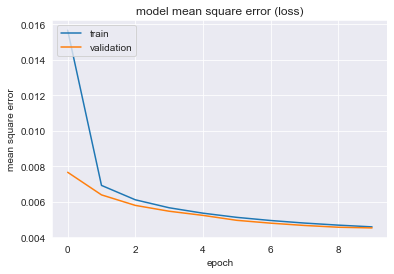

In [30]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model mean square error (loss)')
plt.ylabel('mean square error')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

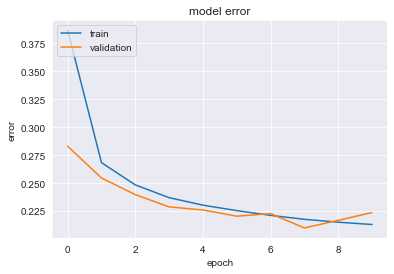

In [32]:
plt.plot(np.ones(len(history.history["accuracy"])) - history.history['accuracy'])
plt.plot(np.ones(len(history.history["accuracy"])) - history.history['val_accuracy'])
plt.title('model error')
plt.ylabel('error')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [41]:
# make model to get intermediate representation in latent space to check size of the intermediate layer
get_encoded_pic = tf.keras.models.Model(inputs=pic_CAE.input, outputs=pic_CAE.get_layer("LATENT_SPACE").output)
# get the intermediate pictures
encoded_pic = get_encoded_pic.predict(test)
print(encoded_pic.shape)
encoded_pic_adj = encoded_pic.reshape((len(test), 8*8*16))
print(encoded_pic_adj.shape)

(6000, 8, 8, 16)
(6000, 1024)


The size of the latent space representation is 1024

In [ ]:
# get the reconstructed pics
reconstructed_pics = pic_CAE.predict(test)
# plot the pictures
plot_cae(test, encoded_pic, reconstructed_pics)

#### 2.3.2 Change padding = "valid" and stride = 2

In [27]:
# implement CAE
input_layer = tf.keras.layers.Input(shape=(32, 32, 3), name="INPUT")
x = tf.keras.layers.Conv2D(filters = 8, kernel_size = (3, 3), strides = 2, activation='relu', padding='valid')(input_layer)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), padding = "valid")(x)
x = tf.keras.layers.Conv2D(filters = 12, kernel_size = (3, 3), strides = 2, activation='relu', padding='valid')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), padding = "valid")(x)
latent_space_rep = tf.keras.layers.Conv2D(filters = 16, kernel_size = (3, 3), strides = 2, activation='relu', padding='valid', name = "LATENT_SPACE")(x)
x = tf.keras.layers.UpSampling2D((2, 2))(latent_space_rep)
x = tf.keras.layers.Conv2D(12, (3, 3), activation='relu', padding='valid')(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
output_layer = tf.keras.layers.Conv2D(3, (3, 3), padding='valid', name="OUTPUT")(x)

In [28]:
pic_CAE = tf.keras.models.Model(input_layer, output_layer)
pic_CAE.compile(optimizer='adam', loss='mse', metrics=["accuracy"])
pic_CAE.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
INPUT (InputLayer)           [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 8)         224       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 12)        876       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 12)          0         
_________________________________________________________________
LATENT_SPACE (Conv2D)        (None, 8, 8, 16)          1744      
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 16, 16, 16)       

In [29]:
# train the model
history = pic_CAE.fit(x = train,
                      y = train,
                      epochs=10,
                      batch_size=64,
                      shuffle=True,
                      validation_data = (valid, valid)) #change this in other version to valid

Epoch 1/10
750/750 [==============================] - 66s 88ms/step - loss: 0.0157 - accuracy: 0.6131 - val_loss: 0.0077 - val_accuracy: 0.7170
Epoch 2/10
750/750 [==============================] - 63s 84ms/step - loss: 0.0069 - accuracy: 0.7316 - val_loss: 0.0064 - val_accuracy: 0.7454
Epoch 3/10
750/750 [==============================] - 63s 85ms/step - loss: 0.0061 - accuracy: 0.7516 - val_loss: 0.0058 - val_accuracy: 0.7603
Epoch 4/10
750/750 [==============================] - 63s 84ms/step - loss: 0.0057 - accuracy: 0.7630 - val_loss: 0.0055 - val_accuracy: 0.7713
Epoch 5/10
750/750 [==============================] - 65s 86ms/step - loss: 0.0054 - accuracy: 0.7697 - val_loss: 0.0052 - val_accuracy: 0.7740
Epoch 6/10
750/750 [==============================] - 65s 87ms/step - loss: 0.0051 - accuracy: 0.7746 - val_loss: 0.0050 - val_accuracy: 0.7795
Epoch 7/10
750/750 [==============================] - 63s 84ms/step - loss: 0.0050 - accuracy: 0.7788 - val_loss: 0.0048 - val_accuracy:

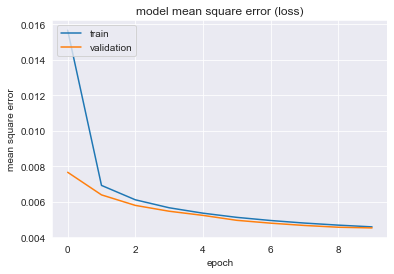

In [30]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model mean square error (loss)')
plt.ylabel('mean square error')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

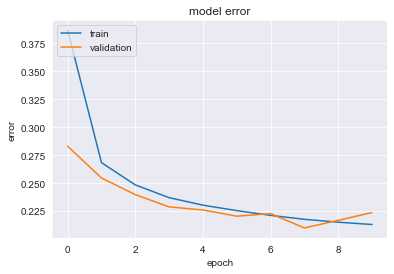

In [32]:
plt.plot(np.ones(len(history.history["accuracy"])) - history.history['accuracy'])
plt.plot(np.ones(len(history.history["accuracy"])) - history.history['val_accuracy'])
plt.title('model error')
plt.ylabel('error')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [41]:
# make model to get intermediate representation in latent space to check size of the intermediate layer
get_encoded_pic = tf.keras.models.Model(inputs=pic_CAE.input, outputs=pic_CAE.get_layer("LATENT_SPACE").output)
# get the intermediate pictures
encoded_pic = get_encoded_pic.predict(test)
print(encoded_pic.shape)
encoded_pic_adj = encoded_pic.reshape((len(test), 8*8*16))
print(encoded_pic_adj.shape)

(6000, 8, 8, 16)
(6000, 1024)


The size of the latent space representation is 1024

In [ ]:
# get the reconstructed pics
reconstructed_pics = pic_CAE.predict(test)
# plot the pictures
plot_cae(test, encoded_pic, reconstructed_pics)